In [43]:
from elasticsearch_dsl import connections, Index, Search
from elasticsearch_dsl.query import Range, Terms, Term
from elasticsearch_dsl.aggs import Terms as PerTerms, Cardinality, Histogram, Min, Max
from pandas import DataFrame, NA, concat
from pathlib import Path
from seaborn import FacetGrid, histplot, set_theme

In [2]:
ELASTIC_HOST = "https://elasticsearch.srv.webis.de"
ELASTIC_PORT = 9200
ELASTIC_USER = "ajjxp"
# As a way to hide the password at least from the notebook, enter a path to a file here, which only contains the password for Elastic.
ELASTIC_PASSWORD_FILE = Path("~/.local/share/passwords/webis-elasticsearch.txt").expanduser()
INDEX = "corpus_mastodon_statuses*"

OUTPUT_PATH = Path("../data")

NUM_EXPLICIT_INSTANCES = 10
NUM_TOP_VALUES_BUCKETS = 50
NUM_TOP_VALUES = 10

# Limit the Elastic searches to a specific date range. Crawling started on 2023-12-21.
DATE_AFTER = "2023-12-01T00:00:00"
## Ca. "2024-01-30T12:00:00" is the time when a new version of the fediverse data was gahtered.
DATE_BEFORE = "2024-02-22T00:00:00"

In [3]:
# Connect to Elastic.
with ELASTIC_PASSWORD_FILE.open("r") as f:
    password = f.readline().strip("\n")
elastic = connections.create_connection(
    hosts=ELASTIC_HOST + ":" + str(ELASTIC_PORT),
    basic_auth=(ELASTIC_USER, password),
    timeout=300
)

In [4]:
# Prepare the date query
date_query = Range(crawled_at={"gte": DATE_AFTER, "lte": DATE_BEFORE, "format" : "date_hour_minute_second"})
date_query.to_dict()

{'range': {'crawled_at': {'gte': '2023-12-01T00:00:00',
   'lte': '2024-02-22T00:00:00',
   'format': 'date_hour_minute_second'}}}

In [5]:
base_search: Search = Index(INDEX)\
    .search()\
    .filter(date_query)
base_search.count()

733422366

In [44]:
# length_bound_search: Search = base_search.params(size=0)
# length_bound_search.aggs\
#     .metric(
#         "min_content_length",
#         Min(field="content.length")
#     )\
#     .metric(
#         "max_content_length",
#         Max(field="content.length")
#     )
# length_bound_aggs = length_bound_search.execute().aggs
# length_bound_aggs

In [67]:
length_hist_search: Search = base_search.params(size=0)
length_hist_search.aggs\
    .bucket(
        "content_length",
        Histogram(field="content.length", interval=1)
    )
length_hist_search.aggs\
    .bucket(
        "account_display_name_length",
        Histogram(field="account.display_name.length", interval=1)
    )
length_hist_search.aggs\
    .bucket(
        "account_note_length",
        Histogram(field="account.note.length", interval=1)
    )
length_hist_search.aggs\
    .bucket(
        "card_description_length",
        Histogram(field="card.description.length", interval=1)
    )
length_hist_search.aggs\
    .bucket(
        "card_title_length",
        Histogram(field="card.title.length", interval=1)
    )
length_hist_search.aggs\
    .bucket(
        "media_attachments_description_length",
        Histogram(field="media_attachments.description.length", interval=1)
    )
length_hist_search.aggs\
    .bucket(
        "spoiler_text_length",
        Histogram(field="spoiler_text.length", interval=1)
    )
length_hist_search.aggs\
    .bucket(
        "tags_name_length",
        Histogram(field="tags.name.length", interval=1)
    )
length_hist_aggs = length_hist_search.execute().aggs
length_hist_aggs

{'tags_name_length': {'buckets': [{'key': 1.0, 'doc_count': ...}

In [68]:
fields = {
    "content_length": "Content",
    "media_attachments_description_length": "Media alt text",
    "spoiler_text_length": "Spoiler",
    "tags_name_length": "Hashtag",
    "account_display_name_length": "Account name",
    "account_note_length": "Account note",
    "card_title_length": "Card title",
    "card_description_length": "Card description",
}
df = concat([
    DataFrame([
        bucket.to_dict()
        for bucket in length_hist_aggs[agg].buckets
    ]).rename(columns={
        "key": "length",
        "doc_count": "count",
    }).assign(field=field)
    if agg in length_hist_aggs else DataFrame()
    for agg, field in fields.items()
])
df

,length,count,field
0,0.0,330105,Content
1,1.0,5354,Content
2,2.0,10646,Content
3,3.0,89385,Content
4,4.0,83944,Content
...,...,...,...
9790,9790.0,0,Card description
9791,9791.0,0,Card description
9792,9792.0,0,Card description
9793,9793.0,0,Card description


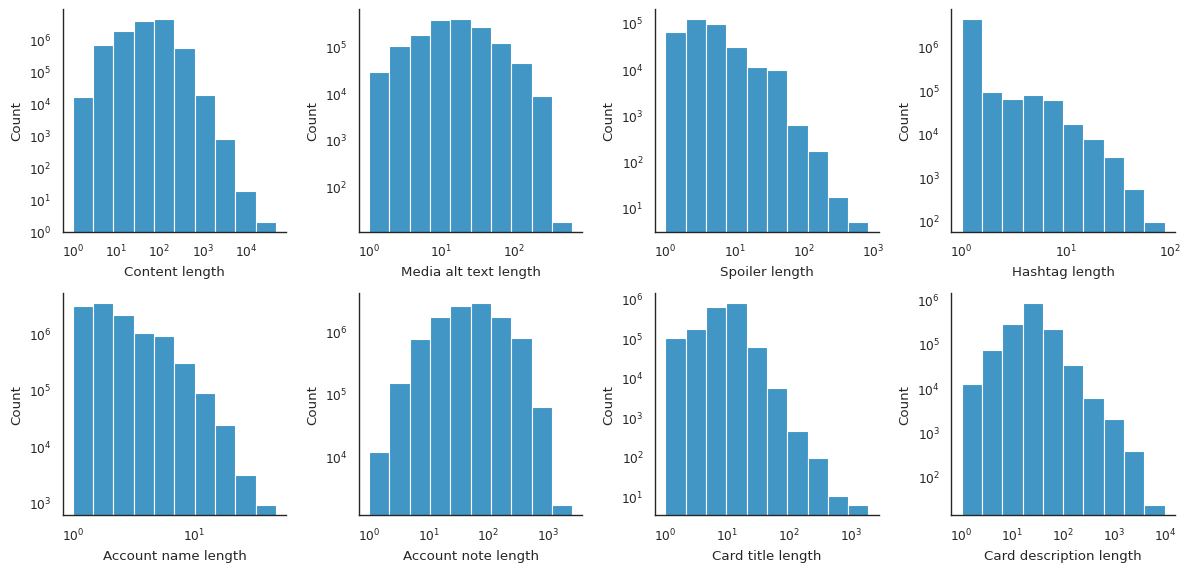

In [69]:
set_theme(style="white", context="paper", palette="colorblind")
g = FacetGrid(
    data=df,
    col="field", 
    col_wrap=4,
    # sharex="col",
    # sharey="row",
    sharex=False,
    sharey=False,
)
g.map_dataframe(
    histplot,
    x="length",
    weights="count",
    bins=10,
    log_scale=(True, True),
    fill=True,
)
g.set_titles(template="")
for name, ax in g.axes_dict.items():
    name: str
    ax.set_yscale("log")
    ax.set_xlabel(name[:1].capitalize() + name[1:] + " length")
g.savefig("../data/histograms-text-lengths.pdf")
# g.figure.tight_layout()
g